In [2]:
import sys
sys.path.append("/home/ubuntu/workspaces/deepinv/")

In [3]:
from datetime import datetime
import deepinv as dinv
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from deepinv.models import DRUNet
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot, plot_curves
from deepinv.optim.phase_retrieval import correct_global_phase, cosine_similarity, spectral_methods
from deepinv.models.complex import to_complex_denoiser

In [4]:
now = datetime.now()
dt_string = now.strftime("%Y%m%d-%H%M%S")

BASE_DIR = Path(".")
DATA_DIR = BASE_DIR / "data"
SAVE_DIR = DATA_DIR / dt_string
FIGURE_DIR = DATA_DIR / "first_results"
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)
Path(SAVE_DIR / "random").mkdir(parents=True, exist_ok=True)
Path(SAVE_DIR / "pseudorandom").mkdir(parents=True, exist_ok=True)

device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
device

print(SAVE_DIR)

Selected GPU 0 with 14925 MB free memory 
data/20240609-084948


In [5]:
# Set up the variable to fetch dataset and operators.
img_size = 99
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)
x.shape

torch.Size([1, 1, 99, 99])

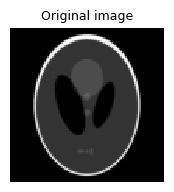

In [6]:
plot(x, titles="Original image")

In [7]:
# generate phase signal

# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to(device)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

# Generate spectral methods results for pseudorandom phase retrieval

In [12]:
repeat = 10

start = 1
end = 299

res_spec = torch.empty((end-start)//2,repeat)
oversampling_ratios = torch.empty((end-start)//2)

In [13]:
for i in trange(start,end,2):
    for j in range(repeat):
        physics = dinv.physics.PseudoRandomPhaseRetrieval(
            n_layers=2,
            input_shape=(1, img_size, img_size),
            output_shape=(1, i, i),
            dtype=torch.cfloat,
            device=device,
        )
        y = physics(x_phase)

        oversampling_ratios[(i - start)//2] = physics.oversampling_ratio
        x_phase_spec = spectral_methods(y, physics,n_iter=2500)
        res_spec[(i - start)//2,j] = cosine_similarity(x_phase, x_phase_spec)

  0%|          | 0/149 [00:00<?, ?it/s]

100%|██████████| 149/149 [25:50<00:00, 10.41s/it]


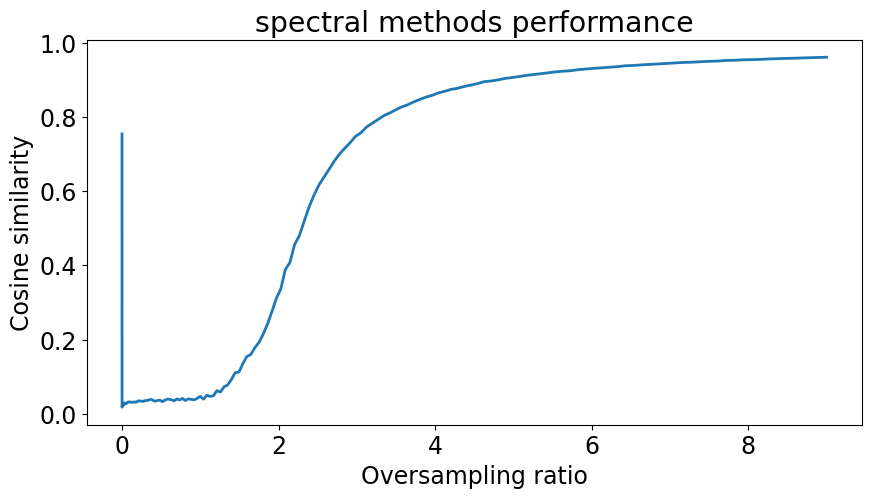

In [14]:
# visualization
plt.figure(figsize=(10, 5))
plt.plot(oversampling_ratios, res_spec.mean(dim=1))
plt.xlabel("Oversampling ratio")
plt.ylabel("Cosine similarity")
plt.title("spectral methods performance")
plt.show()

In [32]:
# save results
torch.save(res_spec, SAVE_DIR / "pseudorandom" / "res_spec.pt")
torch.save(oversampling_ratios, SAVE_DIR / "pseudorandom" / "oversampling_ratios_spec.pt")

# Cosine similarity strangely high at 1

In [30]:
physics = dinv.physics.PseudoRandomPhaseRetrieval(
    n_layers=2,
    input_shape=(1,99,99),
    output_shape=(1,1,1),
    dtype=torch.cfloat,
    device=device,
)

In [28]:
y = physics(x_phase)
torch.allclose(physics.B_adjoint(physics.B(x_phase)), x_phase)

False

In [31]:
cosine_similarity(physics.A_adjoint(y, n_iter=2500),x_phase)

tensor(0.7516, device='cuda:0')

# gradient norm w.r.t. oversampling ratios

In [8]:
oversampling_ratios = []
mean_gradient = []

data_fidelity = L2()

for i in tqdm(range(1, 299, 2)):
    physics = dinv.physics.PseudoRandomPhaseRetrieval(
    n_layers=2,
    input_shape=(1,99,99),
    output_shape=(1,i,i),
    dtype=torch.cfloat,
    device=device,
) 
    y = physics(x_phase)
    oversampling_ratios.append(physics.oversampling_ratio.item())
    mean_gradient.append(data_fidelity.grad(physics.A_adjoint(y, n_iter=2500), y, physics).mean().norm().item())

100%|██████████| 149/149 [02:35<00:00,  1.04s/it]


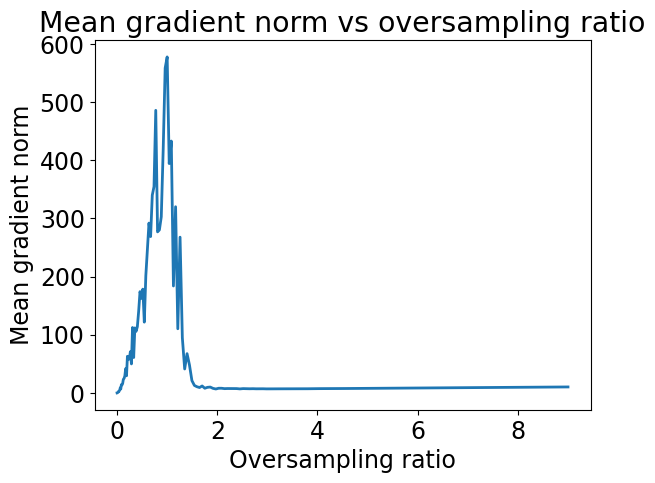

In [9]:
plt.plot(oversampling_ratios, mean_gradient)
plt.xlabel('Oversampling ratio')
plt.ylabel('Mean gradient norm')
plt.title('Mean gradient norm vs oversampling ratio')
plt.show()

# stepsize for oversampling ratio 1

In [70]:
physics = dinv.physics.PseudoRandomPhaseRetrieval(
    n_layers=2,
    input_shape=(1,img_size,img_size),
    output_shape=(1,141,141),
    dtype=torch.cfloat,
    device=device,
)

y = physics(x_phase)

In [71]:
def spectral_methods_wrapper(y, physics, **kwargs):
    x = spectral_methods(y, physics, n_iter=2500, **kwargs)
    z = spectral_methods(y, physics, n_iter=2500, **kwargs)
    return {"est": (x, z)}

In [72]:
# Algorithm parameters
data_fidelity = L2()
prior = dinv.optim.prior.Zero()
params_algo = {"stepsize": 1e-4*physics.oversampling_ratio.item(), "g_params": 0.00}
#params_algo = {"stepsize": 0.05, "g_params": 0.00}
max_iter = 10000
early_stop = True
verbose = True

/opt/conda/envs/deepinv/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/conda/envs/deepinv/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


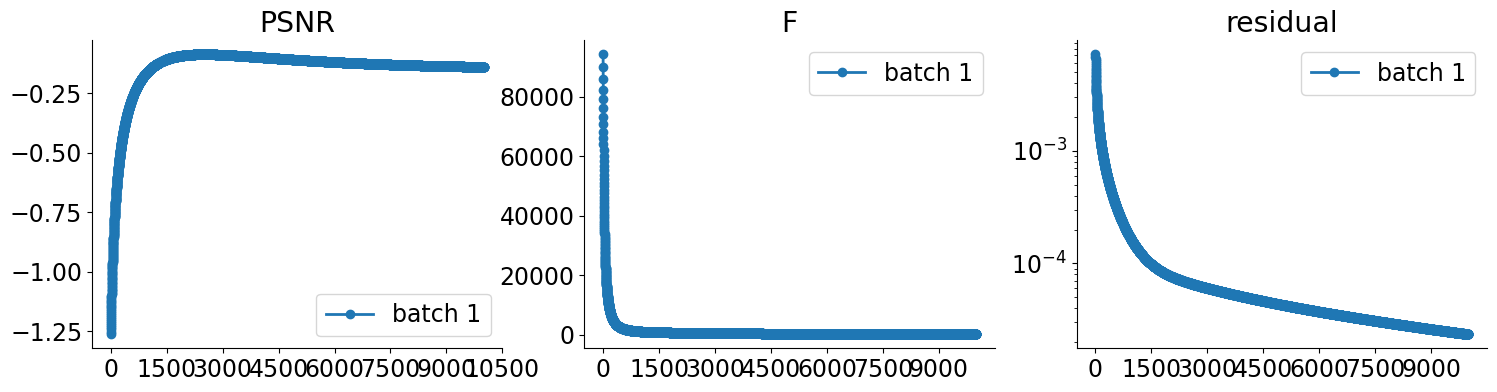

In [73]:
# Instantiate the algorithm class to solve the IP problem.
model = optim_builder(
    iteration="PGD",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=verbose,
    params_algo=params_algo,
    custom_init=spectral_methods_wrapper,
)

# Run the algorithm
x_phase_est, metrics = model(y, physics, x_gt=x_phase, compute_metrics=True)
plot_curves(metrics, show=True)

Image 0, channel 0 does not have a global phase shift.


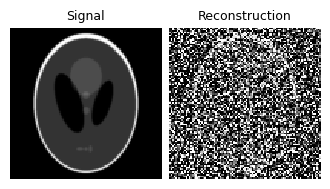

Cosine similarity: tensor(0.3999, device='cuda:0')


In [74]:
# correct possible global phase shifts
x_est = correct_global_phase(x_phase_est, x_phase)
# extract phase information and normalize to the range [0, 1]
x_est = torch.angle(x_est) / torch.pi + 0.5
plot([x, x_est],titles=["Signal","Reconstruction"],rescale_mode='clip')
print("Cosine similarity:", cosine_similarity(x, x_est))

# gradient descent with spectral methods for pseudorandom phase retrieval

In [143]:
repeat = 10

start = 101
end = 141

res_gd_spec = torch.empty((end-start)//2,repeat)
oversampling_ratios = torch.empty((end-start)//2)

data_fidelity = L2()
prior = dinv.optim.prior.Zero()
max_iter = 10000
early_stop = True
verbose = True
step_size = 1e-4
k = 119e-4
b = -118e-4

In [144]:
def spectral_methods_wrapper(y, physics, **kwargs):
    x = spectral_methods(y, physics, n_iter=2500, **kwargs)
    z = spectral_methods(y, physics, n_iter=2500, **kwargs)
    return {"est": (x, z)}

In [78]:
for i in trange(start,end,2):
    params_algo = {"stepsize": k*i**2/(img_size**2)+b, "g_params": 0.00}
    model = optim_builder(
        iteration="PGD",
        prior=prior,
        data_fidelity=data_fidelity,
        early_stop=early_stop,
        max_iter=max_iter,
        verbose=verbose,
        params_algo=params_algo,
        custom_init=spectral_methods_wrapper,
    )
    for j in range(repeat):
        physics = dinv.physics.PseudoRandomPhaseRetrieval(
            n_layers=2,
            input_shape=(1, img_size, img_size),
            output_shape=(1, i, i),
            dtype=torch.cfloat,
            device=device,
        )
        y = physics(x_phase)

        oversampling_ratios[(i - start)//2] = physics.oversampling_ratio

        x_phase_gd_spec, _ = model(y, physics, x_gt=x_phase, compute_metrics=True)

        res_gd_spec[(i - start)//2,j] = cosine_similarity(x_phase, x_phase_gd_spec)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [30:37<00:00, 91.89s/it]


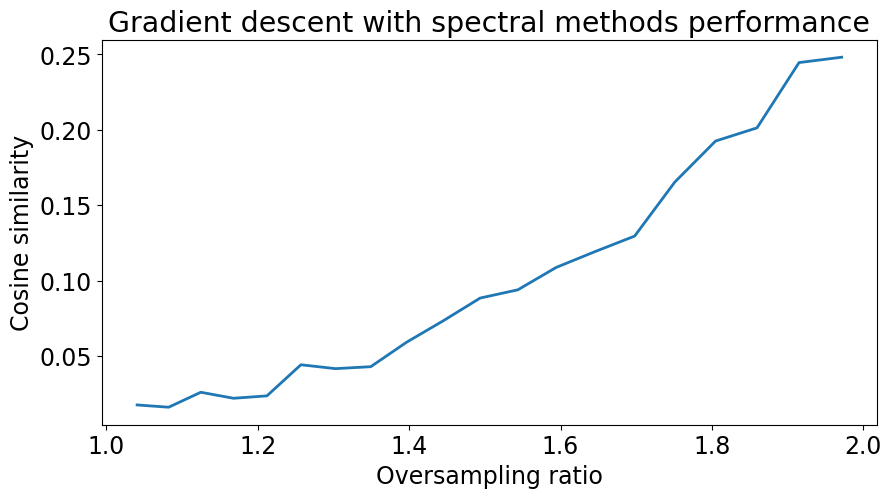

In [79]:
# visualization
plt.figure(figsize=(10, 5))
plt.plot(oversampling_ratios, res_gd_spec.mean(dim=1))
plt.xlabel("Oversampling ratio")
plt.ylabel("Cosine similarity")
plt.title("Gradient descent with spectral methods performance")
plt.show()

In [80]:
# save results
torch.save(res_gd_spec, SAVE_DIR / "pseudorandom" / "res_gd_spec_1-2.pt")
torch.save(oversampling_ratios, SAVE_DIR / "pseudorandom" / "oversampling_ratios_gd_spec_1-2.pt")

# Gradient descent with random initialization for pseudorandom phase retrieval

In [126]:
repeat = 10

start = 141
end = 299

res_gd_rand = torch.empty((end-start)//2,repeat)
oversampling_ratios = torch.empty((end-start)//2)

data_fidelity = L2()
prior = dinv.optim.prior.Zero()
max_iter = 10000
early_stop = True
verbose = True

In [127]:
def random_initialization_wrapper(y, physics, **kwargs):
    x_spec = physics.A_adjoint(y, n_iter=50)
    x = torch.randn_like(x_spec)
    z = torch.randn_like(x_spec)
    return {"est": (x, z)}

In [128]:
for i in trange(start,end,2):
    params_algo = {"stepsize": 0.006*i**2/(img_size**2), "g_params": 0.00}
    model = optim_builder(
        iteration="PGD",
        prior=prior,
        data_fidelity=data_fidelity,
        early_stop=early_stop,
        max_iter=max_iter,
        verbose=verbose,
        params_algo=params_algo,
        custom_init=random_initialization_wrapper,
    )
    for j in range(repeat):
        physics = dinv.physics.PseudoRandomPhaseRetrieval(
            n_layers=2,
            input_shape=(1, img_size, img_size),
            output_shape=(1, i, i),
            dtype=torch.cfloat,
            device=device,
        )
        y = physics(x_phase)

        oversampling_ratios[(i - start)//2] = physics.oversampling_ratio

        x_phase_gd_rand, _ = model(y, physics, x_gt=x_phase, compute_metrics=True)

        res_gd_rand[(i - start)//2,j] = cosine_similarity(x_phase, x_phase_gd_rand)

 85%|████████▍ | 67/79 [3:03:39<33:26, 167.19s/it]  

Iteration 9363, current converge crit. = 9.97E-06, objective = 1.00E-05 
Iteration 7726, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 9674, current converge crit. = 9.99E-06, objective = 1.00E-05 


 86%|████████▌ | 68/79 [3:06:15<30:02, 163.84s/it]

Iteration 5928, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 5603, current converge crit. = 9.98E-06, objective = 1.00E-05 


 87%|████████▋ | 69/79 [3:08:42<26:29, 158.95s/it]

Iteration 8506, current converge crit. = 9.97E-06, objective = 1.00E-05 


 89%|████████▊ | 70/79 [3:11:28<24:09, 161.01s/it]

Iteration 9194, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 8081, current converge crit. = 1.00E-05, objective = 1.00E-05 


 90%|████████▉ | 71/79 [3:14:06<21:19, 159.98s/it]

Iteration 9341, current converge crit. = 9.97E-06, objective = 1.00E-05 
Iteration 7593, current converge crit. = 9.99E-06, objective = 1.00E-05 


 91%|█████████ | 72/79 [3:16:43<18:33, 159.07s/it]

Iteration 9032, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 7590, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 8363, current converge crit. = 9.99E-06, objective = 1.00E-05 


 92%|█████████▏| 73/79 [3:19:28<16:05, 161.00s/it]

Iteration 9819, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 6719, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 8767, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 8118, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 8285, current converge crit. = 9.98E-06, objective = 1.00E-05 


 94%|█████████▎| 74/79 [3:22:03<13:16, 159.27s/it]

Iteration 7312, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 8301, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 7729, current converge crit. = 9.97E-06, objective = 1.00E-05 
Iteration 9307, current converge crit. = 9.97E-06, objective = 1.00E-05 


 95%|█████████▍| 75/79 [3:24:30<10:21, 155.40s/it]

Iteration 8066, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 5727, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 7243, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 8747, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 6499, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 6172, current converge crit. = 9.98E-06, objective = 1.00E-05 


 96%|█████████▌| 76/79 [3:26:49<07:31, 150.55s/it]

Iteration 8323, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 7422, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 5379, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 5222, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 9993, current converge crit. = 9.97E-06, objective = 1.00E-05 
Iteration 7409, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 8087, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 9859, current converge crit. = 9.97E-06, objective = 1.00E-05 


 97%|█████████▋| 77/79 [3:28:58<04:48, 144.17s/it]

Iteration 6346, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 8356, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 6031, current converge crit. = 9.97E-06, objective = 1.00E-05 
Iteration 7785, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 5261, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 6087, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 7145, current converge crit. = 9.98E-06, objective = 1.00E-05 


 99%|█████████▊| 78/79 [3:31:14<02:21, 141.75s/it]

Iteration 9141, current converge crit. = 9.97E-06, objective = 1.00E-05 
Iteration 7871, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 8976, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 5669, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 4525, current converge crit. = 9.97E-06, objective = 1.00E-05 
Iteration 5402, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 8236, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 9241, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 5563, current converge crit. = 9.98E-06, objective = 1.00E-05 


100%|██████████| 79/79 [3:33:12<00:00, 161.94s/it]

Iteration 8412, current converge crit. = 1.00E-05, objective = 1.00E-05 


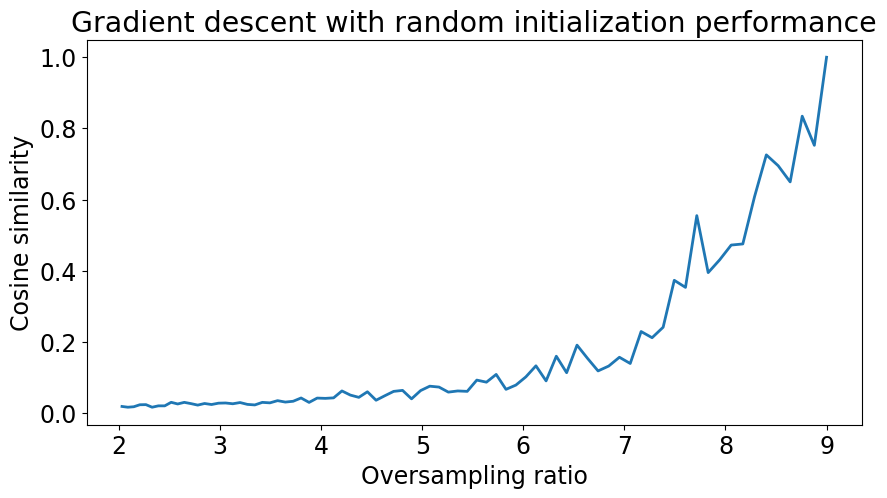

In [130]:
# visualization
plt.figure(figsize=(10, 5))
plt.plot(oversampling_ratios, res_gd_rand.mean(dim=1))
plt.xlabel("Oversampling ratio")
plt.ylabel("Cosine similarity")
plt.title("Gradient descent with random initialization performance")
plt.show()

In [131]:
# save results
torch.save(res_gd_rand, SAVE_DIR / "pseudorandom" / "res_gd_rand_2-9.pt")
torch.save(oversampling_ratios, SAVE_DIR / "pseudorandom" / "oversampling_ratios_gd_rand_2-9.pt")

# overall visualization

In [132]:
print(SAVE_DIR)

data/20240609-084948


In [133]:
oversampling_ratios = torch.load(SAVE_DIR / "pseudorandom" / "oversampling_ratios_spec.pt")

ratio_1 = torch.load(SAVE_DIR / "pseudorandom" / "oversampling_ratios_gd_spec_0-1.pt")
ratio_2 = torch.load(SAVE_DIR / "pseudorandom" / "oversampling_ratios_gd_spec_1-2.pt")
ratio_3 = torch.load(SAVE_DIR / "pseudorandom" / "oversampling_ratios_gd_spec_2-9.pt")

ratio_4 = torch.load(SAVE_DIR / "pseudorandom" / "oversampling_ratios_gd_rand_0-2.pt")
ratio_5 = torch.load(SAVE_DIR / "pseudorandom" / "oversampling_ratios_gd_rand_2-9.pt")

In [134]:
oversampling_ratios.shape

torch.Size([149])

In [135]:
torch.concatenate((ratio_4, ratio_5)) == oversampling_ratios

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True])

In [136]:
res_gd_rand_0_2 = torch.load(SAVE_DIR / "pseudorandom" / "res_gd_rand_0-2.pt")
res_gd_rand_2_9 = torch.load(SAVE_DIR / "pseudorandom" / "res_gd_rand_2-9.pt")
res_gd_rand = torch.concatenate((res_gd_rand_0_2.mean(dim=1), res_gd_rand_2_9.mean(dim=1)))
res_gd_rand.shape

torch.Size([149])

In [137]:
res_gd_spec_0_1 = torch.load(SAVE_DIR / "pseudorandom" / "res_gd_spec_0-1.pt")
res_gd_spec_1_2 = torch.load(SAVE_DIR / "pseudorandom" / "res_gd_spec_1-2.pt")
res_gd_spec_2_9 = torch.load(SAVE_DIR / "pseudorandom" / "res_gd_spec_2-9.pt")
res_gd_spec = torch.concatenate((res_gd_spec_0_1.mean(dim=1), res_gd_spec_1_2.mean(dim=1), res_gd_spec_2_9.mean(dim=1)))
res_gd_spec.shape

torch.Size([149])

In [138]:
res_gd_spec

tensor([0.7548, 0.0159, 0.0192, 0.0202, 0.0219, 0.0254, 0.0259, 0.0303, 0.0271,
        0.0287, 0.0325, 0.0390, 0.0348, 0.0369, 0.0361, 0.0425, 0.0463, 0.0374,
        0.0352, 0.0472, 0.0532, 0.0480, 0.0557, 0.0530, 0.0593, 0.0577, 0.0612,
        0.0628, 0.0568, 0.0549, 0.0660, 0.0688, 0.0745, 0.0733, 0.0829, 0.0722,
        0.0867, 0.0870, 0.0939, 0.1058, 0.0969, 0.1070, 0.0878, 0.1015, 0.1160,
        0.1007, 0.1178, 0.1242, 0.1399, 0.1538, 0.0175, 0.0160, 0.0259, 0.0219,
        0.0235, 0.0442, 0.0416, 0.0429, 0.0591, 0.0733, 0.0884, 0.0939, 0.1087,
        0.1192, 0.1295, 0.1653, 0.1926, 0.2013, 0.2446, 0.2481,    nan, 0.2815,
        0.3150, 0.3624, 0.3887, 0.4367, 0.4961, 0.5342, 0.5985, 0.6194, 0.6878,
        0.7287, 0.7873, 0.8446, 0.9026, 0.9961, 0.9997, 0.9998, 0.9998, 0.9998,
        0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

In [139]:
res_spec = torch.load(SAVE_DIR / "pseudorandom" / "res_spec.pt").mean(dim=1)
res_spec.shape

torch.Size([149])

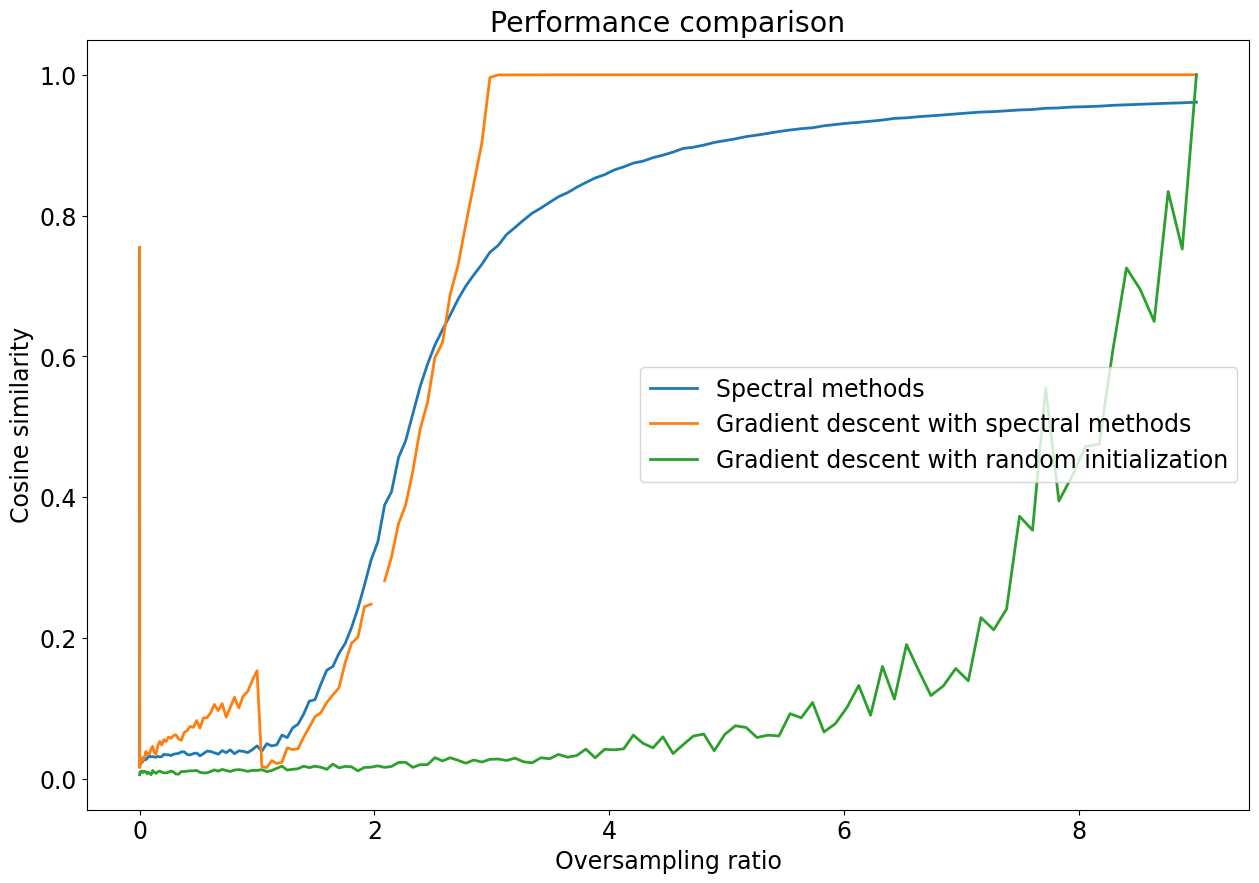

In [142]:
plt.figure(figsize=(15, 10))
plt.plot(oversampling_ratios, res_spec, label="Spectral methods")
plt.plot(oversampling_ratios, res_gd_spec, label="Gradient descent with spectral methods")
plt.plot(oversampling_ratios, res_gd_rand, label="Gradient descent with random initialization")
plt.xlabel("Oversampling ratio")
plt.ylabel("Cosine similarity")
plt.legend()
plt.title("Performance comparison")
plt.show()